In [1]:
import sys

import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings

In [2]:
train = pd.read_csv('../data/rsna-2024-lumbar-spine-degenerative-classification/train.csv')

In [3]:
print(len(train))

1975


In [4]:
train.columns

Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

In [5]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


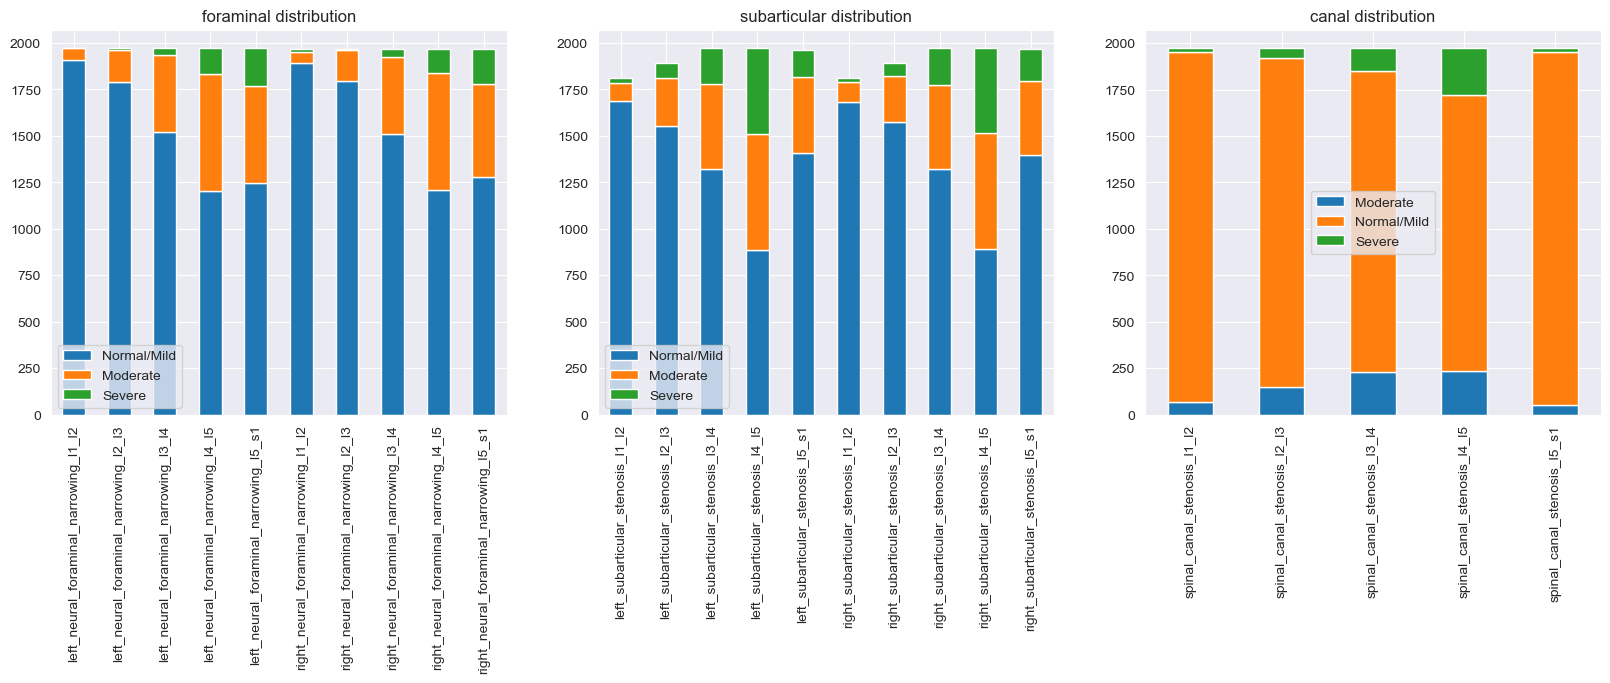

In [6]:
figure, axis = plt.subplots(1, 3, figsize=(20, 5))
for idx, d in enumerate(['foraminal', 'subarticular', 'canal']):
    diagnosis = list(filter(lambda x: x.find(d) > -1, train.columns))
    dff = train[diagnosis]
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        value_counts = dff.apply(pd.value_counts).fillna(0).T
    value_counts.plot(kind='bar', stacked=True, ax=axis[idx])
    axis[idx].set_title(f'{d} distribution')

In [7]:
# List out all of the Studies we have on patients.
part_1 = os.listdir('../data/rsna-2024-lumbar-spine-degenerative-classification/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))

In [8]:
df_meta_f = pd.read_csv('../data/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [9]:
p1 = [(x, f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{x}") for x in part_1]
meta_obj = {p[0]: {'folder_path': p[1],
                   'SeriesInstanceUIDs': []
                   }
            for p in p1}

In [10]:
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1,
               os.listdir(meta_obj[m]['folder_path'])
               )
    )

In [11]:
# grabs the correspoding series descriptions
for k in tqdm(meta_obj):
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        if 'SeriesDescriptions' not in meta_obj[k]:
            meta_obj[k]['SeriesDescriptions'] = []
        try:
            meta_obj[k]['SeriesDescriptions'].append(
                df_meta_f[(df_meta_f['study_id'] == int(k)) &
                          (df_meta_f['series_id'] == int(s))]['series_description'].iloc[0])
        except:
            print("Failed on", s, k)

100%|██████████| 1975/1975 [00:00<00:00, 2760.20it/s]


In [12]:
meta_obj[list(meta_obj.keys())[1]]

{'folder_path': '../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/213335325',
 'SeriesInstanceUIDs': ['1062372272', '858832151', '1153454550'],
 'SeriesDescriptions': ['Sagittal T1', 'Sagittal T2/STIR', 'Axial T2']}

In [13]:
patient = train.iloc[1]

In [14]:
ptobj = meta_obj[str(patient['study_id'])]

In [15]:
print(ptobj)

{'folder_path': '../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740', 'SeriesInstanceUIDs': ['3486248476', '3666319702', '3201256954'], 'SeriesDescriptions': ['Sagittal T1', 'Sagittal T2/STIR', 'Axial T2']}


In [16]:
# Get data into the format
"""
im_list_dcm = {
    '{SeriesInstanceUID}': {
        'images': [
            {'SOPInstanceUID': ...,
             'dicom': PyDicom object
            },
            ...,
        ],
        'description': # SeriesDescription
    },
    ...
}
"""
im_list_dcm = {}
for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    im_list_dcm[i] = {'images': [], 'description': ptobj['SeriesDescriptions'][idx]}
    images = glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm")
    for j in sorted(images, key=lambda x: int(x.split('\\')[-1].split("/")[-1].replace('.dcm', ''))):
        im_list_dcm[i]['images'].append({
            'SOPInstanceUID': j.split('\\')[-1].split("/")[-1].replace('.dcm', ''),
            'dicom': pydicom.dcmread(j)})

In [17]:
# Function to display images
def display_images(images, title, max_images_per_row=4):
    # Calculate the number of rows needed
    num_images = len(images)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Ceiling division

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(5, 1.5 * num_rows))

    # Flatten axes array for easier looping if there are multiple rows
    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable for consistency

    # Plot each image
    for idx, image in enumerate(images):
        ax = axes[idx]
        ax.imshow(image, cmap='gray')  # Assuming grayscale for simplicity, change cmap as needed
        ax.axis('off')  # Hide axes

    # Turn off unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()

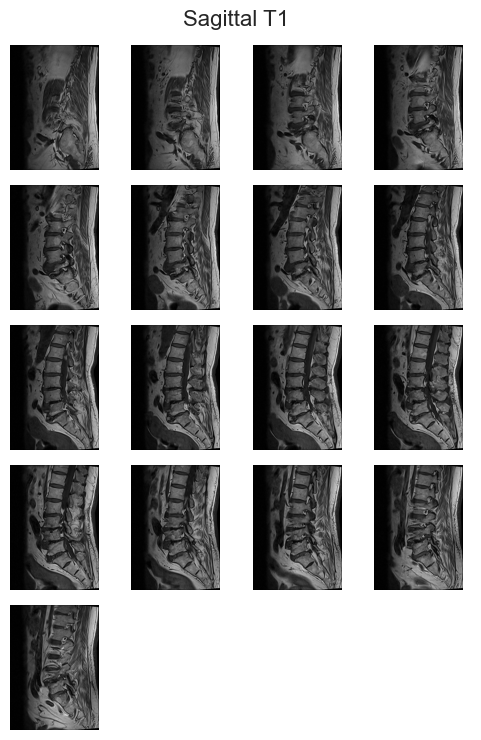

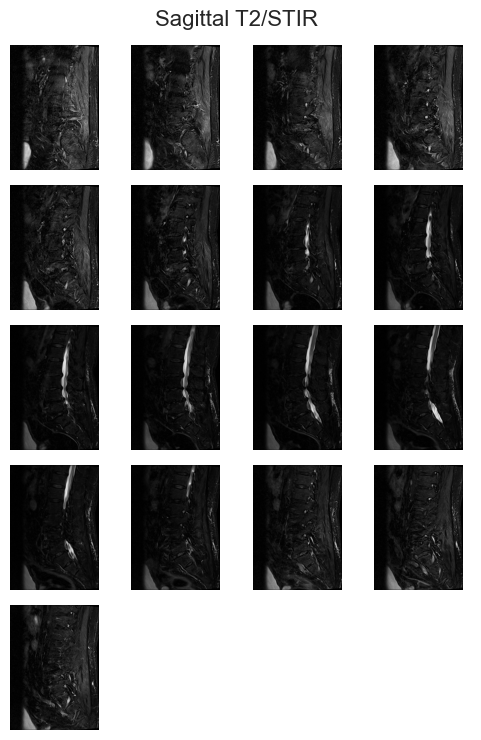

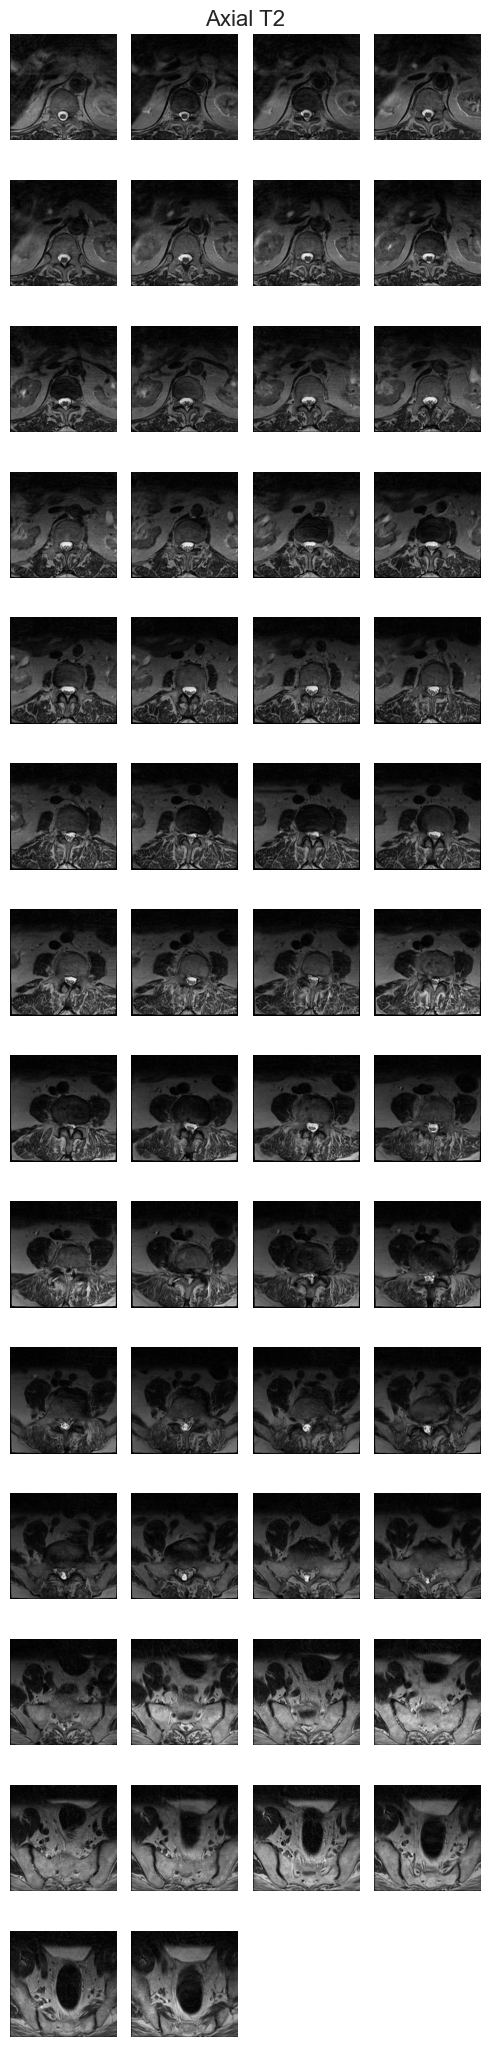

In [18]:
for i in im_list_dcm:
    display_images([x['dicom'].pixel_array for x in im_list_dcm[i]['images']],
                   im_list_dcm[i]['description'])

In [19]:
df_coor = pd.read_csv('../data/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

In [20]:
df_coor.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [21]:
def display_coor_on_img(c, i, title):
    center_coordinates = (int(c['x']), int(c['y']))
    radius = 10
    color = (255, 0, 0)  # Red color in BGR
    thickness = 2
    IMG = i['dicom'].pixel_array
    IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    IMG_with_circle = cv2.circle(IMG_normalized.copy(), center_coordinates, radius, color, thickness)

    # Convert the image from BGR to RGB for correct color display in matplotlib
    IMG_with_circle = cv2.cvtColor(IMG_with_circle, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(IMG_with_circle)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(title)
    plt.show()

In [22]:
coor_entries = df_coor[df_coor['study_id'] == int(patient['study_id'])]

Only showing severe cases for this patient


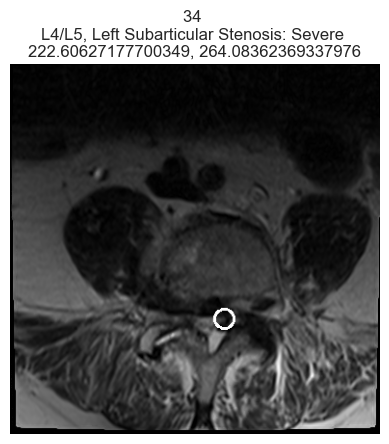

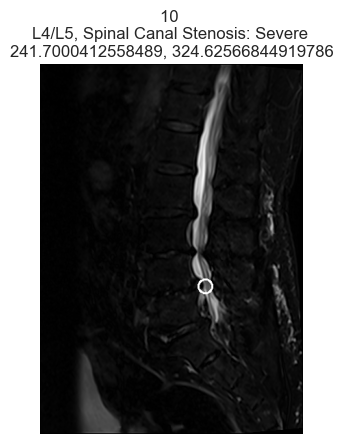

In [23]:
print("Only showing severe cases for this patient")
for idc, c in coor_entries.iterrows():
    for i in im_list_dcm[str(c['series_id'])]['images']:
        if int(i['SOPInstanceUID']) == int(c['instance_number']):
            try:
                patient_severity = patient[
                    f"{c['condition'].lower().replace(' ', '_')}_{c['level'].lower().replace('/', '_')}"
                ]
            except Exception as e:
                patient_severity = "unknown severity"
            title = f"{i['SOPInstanceUID']} \n{c['level']}, {c['condition']}: {patient_severity} \n{c['x']}, {c['y']}"
            if patient_severity == 'Severe':
                display_coor_on_img(c, i, title)

In [24]:
im_list_dcm.keys()

dict_keys(['3486248476', '3666319702', '3201256954'])

In [25]:
im_list_dcm['3486248476']

{'images': [{'SOPInstanceUID': '1',
   'dicom': Dataset.file_meta -------------------------------
   (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
   (0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
   (0002, 0003) Media Storage SOP Instance UID      UI: 4646740.1.1
   (0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
   (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
   (0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
   -------------------------------------------------
   (0008, 0018) SOP Instance UID                    UI: 4646740.1.1
   (0008, 0023) Content Date                        DA: '20240503'
   (0008, 0033) Content Time                        TM: '223734.008099'
   (0008, 103e) Series Description                  LO: ''
   (0010, 0020) Patient ID                          LO: '4646740'
   (0018, 0050) Slice Thickness                     DS: '3.0'
   (0018, 0088) Spacin

In [26]:
t1_images = np.array([x['dicom'].pixel_array for x in im_list_dcm['3486248476']['images']])
t1_images.shape

(17, 540, 384)

In [4]:
files = glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/11340341/1224932122/*.dcm")
files = [pydicom.dcmread(fname) for fname in files]
slices = []

skipcount = 0

for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d


skipped, no SliceLocation: 0


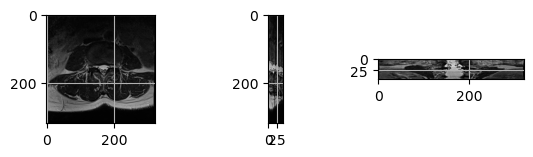

In [7]:
import torch
# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1] / ps[0]
sag_aspect = ps[1] / ss
cor_aspect = ss / ps[0]


def show_mid_slices(img4d, aspect=False):
    if torch.is_tensor(img4d):
        try:
            img4d = img4d.detach().cpu().numpy()
        except Exception as e:
            pass
        
    for i in range(len(img4d)):
        img3d = img4d[i]
        img_shape = img3d.shape
                                
        a1 = plt.subplot(3, 3, i * 3 + 1)
        a1.imshow(img3d[:, :, img_shape[2] // 2], cmap="gray")
        a1.grid(None)
        if aspect:
            a1.set_aspect(ax_aspect)
    
        a2 = plt.subplot(3, 3, i * 3 + 2)
        a2.imshow(img3d[:, img_shape[1] // 2, :], cmap="gray")
        a2.grid(None)
        if aspect:
            a2.set_aspect(sag_aspect)
    
        a3 = plt.subplot(3, 3, i * 3 + 3)
        a3.imshow(img3d[img_shape[0] // 2, :, :].T, cmap="gray")
        a3.grid(None)
        if aspect:
            a3.set_aspect(cor_aspect)
            
    plt.show()


show_mid_slices(np.expand_dims(img3d, 0))

In [7]:
files = glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/11340341/1224932122/*.dcm")
files = sorted(files, key=lambda x: int(x.split('\\')[-1].split("/")[-1].split('.')[0]))
slices = [pydicom.dcmread(fname) for fname in files]

img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

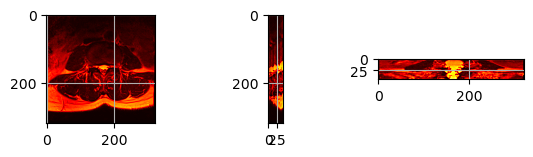

In [8]:
show_mid_slices(np.expand_dims(img3d, 0))

In [9]:
ds = pydicom.dcmread("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/3486248476/9.dcm")

# get the pixel information into a numpy array
data = ds.pixel_array
print('The image has {} x {} voxels'.format(data.shape[0],
                                            data.shape[1]))

The image has 540 x 384 voxels


In [2]:
from rsna_dataloader import *

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

training_data = training_data.dropna()
training_data = training_data.groupby("study_id").filter(lambda x: len(x) != 75)

In [13]:
import torchio as tio
import torch.nn as nn

transform_3d_train = tio.Compose([
    nn.AdaptiveAvgPool3d((128, 128, 128)),
    tio.RescaleIntensity(out_min_max=(0, 1)),
])
testset = PatientLevelDataset(os.path.join(data_basepath, "train_images"), training_data, transform_3d=transform_3d_train)
img = testset[0][0]

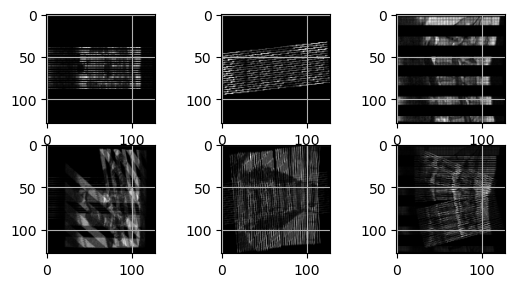

In [14]:
show_mid_slices(img)

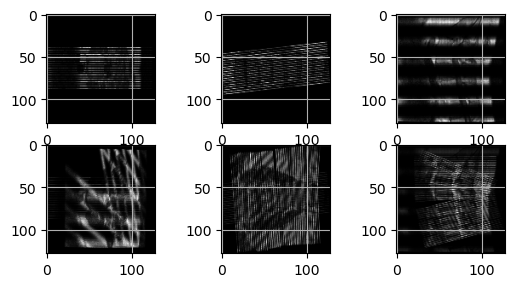

In [13]:
t1 = tio.Compose([
        tio.Resize((512, 512, 512), image_interpolation="gaussian"),
        tio.Resize((128, 128, 128), image_interpolation="gaussian"),
        # nn.AdaptiveMaxPool3d((128, 128, 128)),
        tio.RescaleIntensity(out_min_max=(0, 1)),
])(img.to(torch.float))
show_mid_slices(t1)

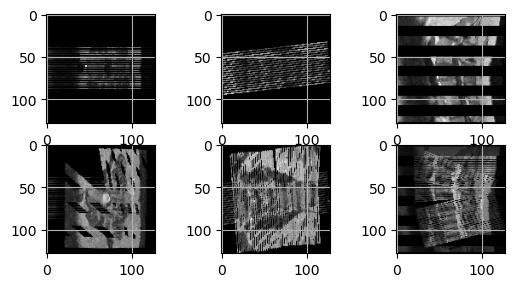

In [18]:
t2 = tio.Compose([
        nn.AdaptiveMaxPool3d((128, 128, 128)),
        tio.RescaleIntensity(out_min_max=(0, 1)),
])(img.to(torch.float))
show_mid_slices(t2)

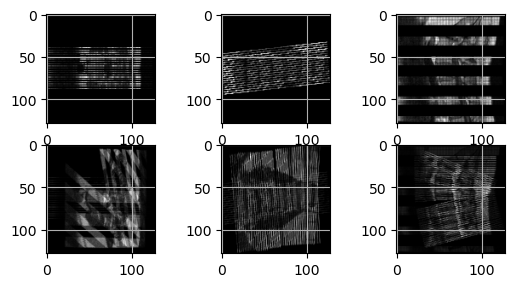

In [19]:
t3 = tio.Compose([
    nn.AdaptiveAvgPool3d((128, 128, 128)),
    tio.RescaleIntensity(out_min_max=(0, 1)),
])(img.to(torch.float))
show_mid_slices(t3)

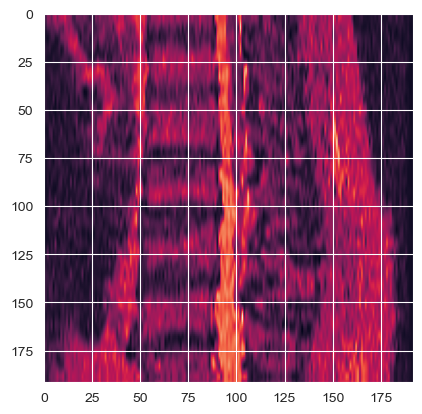

In [54]:
from scipy import ndimage
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

img = testset[0][0][1]
img_mid = img[:, :, img.shape[2] // 2]

#model = GaussianMixture(n_components=2)

# model = KMeans(n_clusters=2)
# model = model.fit(img_mid.flatten().reshape(-1, 1))
#
# mask = model.predict(img_mid.flatten().reshape(-1, 1)).reshape(img_mid.shape)

plt.imshow((img_mid * 255 // torch.max(img_mid)).numpy().astype(np.uint8))
plt.show()

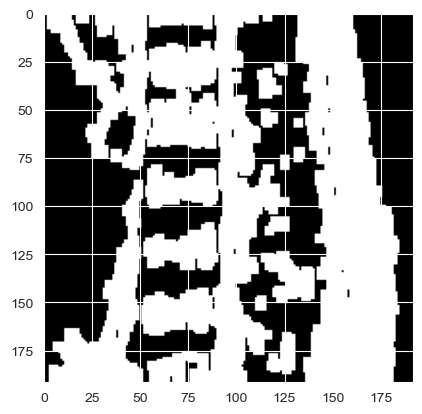

In [36]:
thresh = cv2.adaptiveThreshold((img_mid * 255).numpy().astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,555,11)
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
# mask = thresh

plt.imshow(mask, cmap="gray")

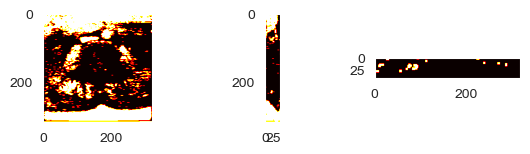

In [37]:
def axial_threshold_mask_2d(img2d):
    if torch.is_tensor(img2d):
        img2d = img2d.numpy()
    thresh = cv2.adaptiveThreshold((img2d * 255).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,555,11)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return mask

def axial_threshold_mask_3d(img3d):
    return np.stack([axial_threshold_mask_2d(slice) for slice in img3d[:,:]])
        
show_mid_slices(np.expand_dims(axial_threshold_mask_3d(img3d), 0))

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import MiniBatchKMeans, SpectralClustering
from sklearn.cluster import DBSCAN

# Axial clustering and slicing

In [39]:
import open3d as o3d
import cv2

def axial_point_cloud_from_mask(img3d, visualize=False):
    # img_ = img[len(img)//2 - 15:len(img)//2 + 15] # Sagittal
    img_ = axial_threshold_mask_3d(img3d)# [:,:,len(img)//2 - 15:len(img)//2 + 15] # Axial
    
    if torch.is_tensor(img_):
        img_ = img_.numpy()
        
    pcd = o3d.geometry.PointCloud()
    
    # x,y,z=np.where((img_>0.35) & (img_<=0.4)) # Sagittal T1 stack
    x,y,z=np.where(img_ > 0.8) #((img_>0.7)) & (img_<=0.9)) # Axial T2 stack
    # x,y,z=np.where((img_>0.42) & (img_<=0.48)) # Sagittal T2/STIR stack
    
    index_voxel=np.vstack((x,y,z))
    grid_index_array=index_voxel.T
    
    pcd.points = o3d.utility.Vector3dVector(grid_index_array)
    
    colors = np.array([img3d[x,y,z] for x,y,z in grid_index_array]) 
    # colors = cv2.cvtColor(colors,cv2.COLOR_GRAY2RGB)
    colors_rgb = np.stack([colors, colors, colors], axis=1)
    pcd.colors = o3d.utility.Vector3dVector(colors_rgb)
    
    if visualize:
        o3d.visualization.draw_geometries([pcd])
        
    return pcd, (x,y,z), colors_rgb

In [55]:
pcd, (x, y, z), colors_rgb = axial_point_cloud_from_mask(img, visualize=True)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [83]:
def get_level_boxes_from_axial_pc(x, y, z, n_axial_clusters=9, n_columnar_clusters=5):
    X = np.column_stack((y,z))
    kmeans = KMeans(n_clusters=n_axial_clusters).fit(X)
    
    y_centroids = sorted([e[0] for e in kmeans.cluster_centers_]) 
    z_centroids = sorted([e[1] for e in kmeans.cluster_centers_])
    
    y_bounds = (y_centroids[2], y_centroids[6])
    z_bounds = (z_centroids[2], z_centroids[6])
    
    cluster_indices = np.where((y > y_bounds[0]) & (y < y_bounds[1]) & (z > z_bounds[0]) & (z < z_bounds[1]))[0]
    
    kmeans_2 = KMeans(n_clusters=n_columnar_clusters+2).fit(x[cluster_indices].reshape(-1,1))
    x_centroids = sorted([e[0] for e in kmeans_2.cluster_centers_])
                
    return [((x_centroids[i], x_centroids[i + 1]), y_bounds, z_bounds) for i in range(n_columnar_clusters+1)]    

In [84]:
boxes = get_level_boxes_from_axial_pc(x, y, z)
boxes

[((10.192579339570571, 33.42519174432828),
  (44.348807047543986, 153.4658212748132),
  (31.044549121133407, 158.5000153046139)),
 ((33.42519174432828, 60.51255802926092),
  (44.348807047543986, 153.4658212748132),
  (31.044549121133407, 158.5000153046139)),
 ((60.51255802926092, 91.02233903282894),
  (44.348807047543986, 153.4658212748132),
  (31.044549121133407, 158.5000153046139)),
 ((91.02233903282894, 121.61276429773751),
  (44.348807047543986, 153.4658212748132),
  (31.044549121133407, 158.5000153046139)),
 ((121.61276429773751, 152.86202617682937),
  (44.348807047543986, 153.4658212748132),
  (31.044549121133407, 158.5000153046139)),
 ((152.86202617682937, 180.1478247410268),
  (44.348807047543986, 153.4658212748132),
  (31.044549121133407, 158.5000153046139))]

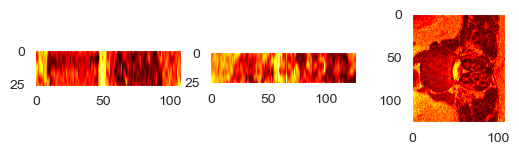

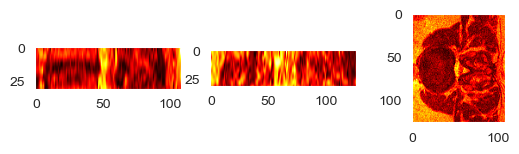

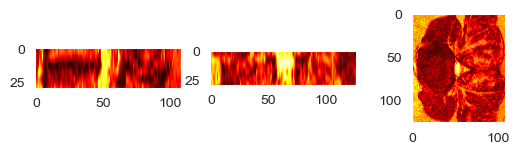

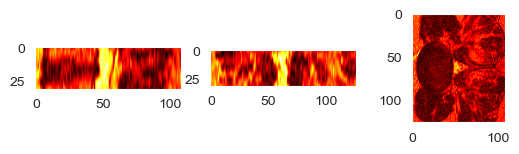

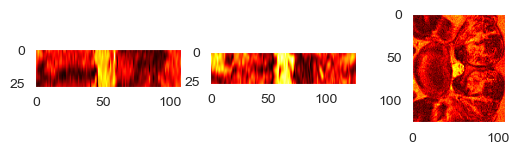

In [86]:
for box in boxes[1:]:
    x_bounds, y_bounds, z_bounds = box
    x_s, x_e = x_bounds
    y_s, y_e = y_bounds
    z_s, z_e = z_bounds
    
    x_s = int(x_s)
    x_e = int(x_e)
    y_s = int(y_s)
    y_e = int(y_e)
    z_s = int(z_s)
    z_e = int(z_e)

    show_mid_slices(img[x_s:x_e,y_s:y_e,z_s:z_e].unsqueeze(0))

# Sagittal slicing

In [44]:
img = testset[0][0][0]

In [45]:
import open3d as o3d
import cv2

img_ = img[len(img)//2 - 15:len(img)//2 + 15] # Sagittal
# img_ = img[:,:,len(img)//2 - 15:len(img)//2 + 15] # Axial

print(img_.numpy().shape)

pcd = o3d.geometry.PointCloud()

x,y,z=np.where((img_>0.35) & (img_<=0.4)) # Sagittal T1 stack
# x,y,z=np.where((img_>0.7) & (img_<=0.9)) # Axial T2 stack
# x,y,z=np.where((img_>0.42) & (img_<=0.48)) # Sagittal T2/STIR stack

index_voxel=np.vstack((x,y,z))
grid_index_array=index_voxel.T

pcd.points = o3d.utility.Vector3dVector(grid_index_array)

colors = np.array([img[x,y,z].numpy() for x,y,z in grid_index_array]) 
# colors = cv2.cvtColor(colors,cv2.COLOR_GRAY2RGB)
colors_rgb = np.stack([colors, colors, colors], axis=1)
print(colors.shape, colors[0])

pcd.colors = o3d.utility.Vector3dVector(colors_rgb)
o3d.visualization.draw_geometries([pcd])

(30, 192, 192)
(118428,) 0.1552
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [46]:
n_clusters = 10

X = np.column_stack((y,x)) # Sagittal
# X = np.column_stack((x,z)) # Axial
# X = np.column_stack((x/len(x),y/len(y),z/len(z),colors))

# kmeans = SpectralClustering(n_clusters=n_clusters).fit(X)
kmeans = KMeans(n_clusters=n_clusters).fit(X)
# cluster_indices = np.where(kmeans.labels_ == 1)[0]

colors_ =  1 - (1 + np.stack([kmeans.labels_, kmeans.labels_, kmeans.labels_], axis=1)) / n_clusters
print(colors_.shape, colors_[0])

cluster = pcd
# cluster = pcd.select_by_index(cluster_indices)

cluster.colors = o3d.utility.Vector3dVector(colors_)
o3d.visualization.draw_geometries([cluster])

(118428, 3) [0. 0. 0.]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [47]:
sorted(list(enumerate(kmeans.cluster_centers_)), key=lambda x: x[1][0])

[(9, array([10.11948124, 15.41197572])),
 (0, array([29.04198746, 13.8022859 ])),
 (7, array([46.932594  , 13.87679778])),
 (2, array([66.28660777, 14.24736143])),
 (6, array([89.76315187, 14.23409941])),
 (8, array([114.92911953,  14.54244126])),
 (1, array([141.07224959,   6.81432361])),
 (5, array([141.4534375 ,  22.23265625])),
 (3, array([165.08615829,  15.28333936])),
 (4, array([182.78131198,  14.55347063]))]

In [48]:
cluster_indices = np.where((y > 140) & (y < 163))[0]
cluster = pcd.select_by_index(cluster_indices)
o3d.visualization.draw_geometries([cluster])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [49]:
n_clusters = 3

X_2 = np.column_stack((z[cluster_indices],y[cluster_indices]))
kmeans_2 = KMeans(n_clusters=n_clusters).fit(X_2)
sorted(list(enumerate(kmeans_2.cluster_centers_)), key=lambda x: x[1][0])

[(2, array([ 53.63436642, 151.59748921])),
 (0, array([ 93.23945872, 149.87781918])),
 (1, array([151.02504776, 152.84843982]))]

In [50]:
cluster_indices = np.where((y > 140) & (y < 163) & (z > 53) & (z < 151))[0]
cluster = pcd.select_by_index(cluster_indices)
o3d.visualization.draw_geometries([cluster])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


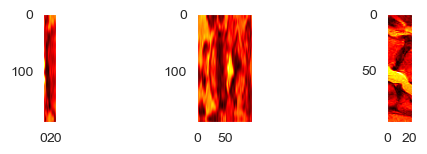

In [51]:
show_mid_slices(img[:,140:163,53:151].unsqueeze(0))

In [52]:
n_clusters = 3

X_3 = np.column_stack((x[cluster_indices],z[cluster_indices]))
kmeans_3 = KMeans(n_clusters=n_clusters).fit(X_3)
sorted(list(enumerate(kmeans_3.cluster_centers_)), key=lambda x: x[1][0])

[(1, array([ 13.18393782, 136.72582038])),
 (0, array([13.31156222, 75.42041777])),
 (2, array([ 15.86689775, 100.51542461]))]

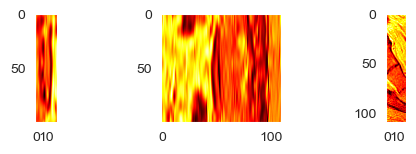

In [53]:
show_mid_slices(img[50:150,163:183,53:163].unsqueeze(0))

In [24]:
import torchio as tio
from rsna_dataloader import *

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

df = TRAINING_DATA.dropna()
# This drops any subjects with nans

filtered_df = pd.DataFrame(columns=df.columns)
for series_desc in CONDITIONS.keys():
    subset = df[df['series_description'] == series_desc]
    if series_desc == "Sagittal T2/STIR":
        subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
    else:
        subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
    filtered_df = pd.concat([filtered_df, subset])

filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

series_descs = {e[0]: e[1] for e in df[["series_id", "series_description"]].drop_duplicates().values}

grid = read_study_as_voxel_grid_v2("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/46494080", series_type_dict=series_descs, img_size=(256,256))

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


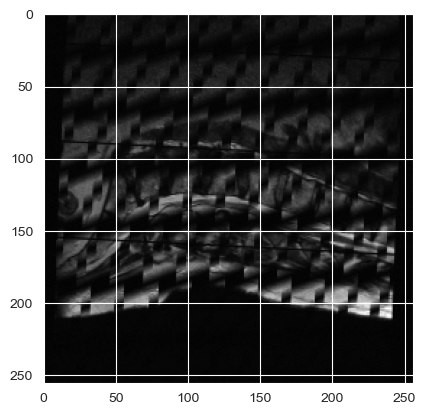

In [44]:
transform = tio.Compose([
        tio.ZNormalization(),
        tio.RandomAffine(p=1, image_interpolation="linear"),
        tio.RandomNoise(p=1),
        tio.RandomBlur(std=(0.1, 0.1), p=1),
        tio.RandomGamma(log_gamma=(0.3, 0.3), p=1),
        tio.RandomSpike(1, intensity=(0.2, 0.2), p=1),
        tio.RescaleIntensity((0, 1)),
    ])

res = transform(grid)

import matplotlib.pyplot as plt

plt.imshow(res[2, 128], cmap="gray")

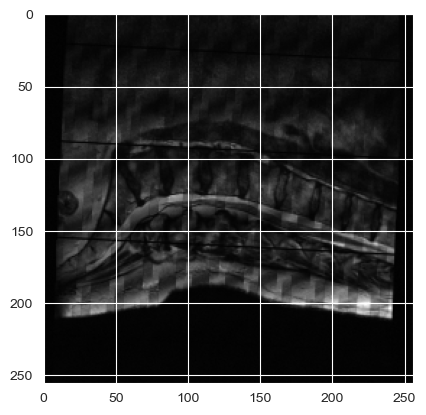

In [47]:
plt.imshow(res[2, 127] + res[2, 128] + res[2, 129], cmap="gray")